# Modelado y entrenamiento de Redes Neuronales Profundas

Objetivos:

- Separar los dataset para entrenar distintos modelos:
    - Dataset completo.
    - Por sexo.
- Modelar redes neuronales que tengan como objetivo predecir el comportamiento del animal a partir de los datos de:
    - 1 segundo de mediciones (capa de entrada de: 10 muestras * 4 Variables por muestra = 40 unidades de entrada).
    - 5 segundos de mediciones (capa de entrada de: 50 muestras * 4 Variables por muestra = 200 unidades de entrada). 
        - Predice el comportamiento del ultimo segundo.
    - Los comportamientos a predecir de acuerdo a los dataset separados son:
        - Dataset 1 - tabla-resumen.csv - 10 
        - Dataset 2 - estudio3.csv - 12 
- Evaluar los modelos para cada tipo de dataset tomado.


Después del análisis exploratorio, pasamos a enumerar los pasos para entrenar las distintos modelos de redes neuronales.

1. Limpieza de datasets a considerar.
2. Generar split de datos: Train, test, validation.
3. Correr entrenamiento de los modelos y guardar los distintos modelos.
4. Evaluar modelos sobre el mismo set de validación, que no fue utilizado en el proceso de entrenamiento.

De estos pasos, 1 y 2 se realizaron en el EDA. Se procede entonces a cargar los datos, entrenar y guardar los distintos modelos.



### 1 - Carga de dataset
Se cargan los datasets previamente generados en el EDA.

In [27]:
!pwd
!ls
%cd meleros/notebooks/
!pwd
!ls

/home/jovyan/meleros/notebooks
1-eda-analisis-exploratorio.ipynb	 model_estudio3_1seg_macho_topology1.h5
2-rn_entrenamiento.ipynb		 model_estudio3_1seg_macho_topology2.h5
2-rnr_entrenamiento.ipynb		 model_estudio3_1seg_macho_topology3.h5
3-rn_evaluacion.ipynb			 model_estudio3_1seg_topology1.h5
3-rnr_evaluacion.ipynb			 model_estudio3_1seg_topology2.h5
dev					 model_estudio3_1seg_topology3.h5
estudio3_1seg_labels_mapping.json	 models
model_estudio3_1seg_hembra_topology1.h5  resultados_modelos_estudio3.csv
model_estudio3_1seg_hembra_topology2.h5  resultados_modelos_estudio3.png
model_estudio3_1seg_hembra_topology3.h5
[Errno 2] No such file or directory: 'meleros/notebooks/'
/home/jovyan/meleros/notebooks
/home/jovyan/meleros/notebooks
1-eda-analisis-exploratorio.ipynb	 model_estudio3_1seg_macho_topology1.h5
2-rn_entrenamiento.ipynb		 model_estudio3_1seg_macho_topology2.h5
2-rnr_entrenamiento.ipynb		 model_estudio3_1seg_macho_topology3.h5
3-rn_evaluacion.ipynb			 model_estudio3_1seg_top

In [28]:
import pandas as pd

# Dataset generico 1 segundo
estudio3_1seg_train = pd.read_csv('../data/2-procesada/estudio3_normalizado_1seg_train.csv')
estudio3_1seg_test = pd.read_csv('../data/2-procesada/estudio3_normalizado_1seg_test.csv')
estudio3_1seg_val = pd.read_csv('../data/2-procesada/estudio3_normalizado_1seg_val.csv')
# Dataset machos 1 segundo
estudio3_1seg_macho_train = pd.read_csv('../data/2-procesada/estudio3_normalizado_1seg_macho_train.csv')
estudio3_1seg_macho_test = pd.read_csv('../data/2-procesada/estudio3_normalizado_1seg_macho_test.csv')
estudio3_1seg_macho_val = pd.read_csv('../data/2-procesada/estudio3_normalizado_1seg_macho_val.csv')
# Dataset hembras 1 segundo
estudio3_1seg_hembra_train = pd.read_csv('../data/2-procesada/estudio3_normalizado_1seg_hembra_train.csv')
estudio3_1seg_hembra_test = pd.read_csv('../data/2-procesada/estudio3_normalizado_1seg_hembra_test.csv')
estudio3_1seg_hembra_val = pd.read_csv('../data/2-procesada/estudio3_normalizado_1seg_hembra_val.csv')

Procedemos a entrenar las redes con distintas topologías deseadas.

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
import numpy as np
import json

topologies = [
    [20],              # One hidden layer
    [30, 15],          # Two hidden layers
    [35, 25, 15]       # Three hidden layers
]

def create_model(input_shape, output_shape, topology):
    model = Sequential()
    model.add(Dense(topology[0], activation='relu', input_shape=(input_shape,)))
    
    for units in topology[1:]:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(0.2))
    
    model.add(Dense(output_shape, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_models(dataset_name: str, train_df, test_df, topologies):
    
    X_train = train_df.drop(columns=['Comportamiento', 'Sexo'])
    y_train = pd.get_dummies(train_df['Comportamiento'])
    X_test = test_df.drop(columns=['Comportamiento', 'Sexo'])
    y_test = pd.get_dummies(test_df['Comportamiento'])
    # Check the label mappings are the same
    assert all(y_train.columns == y_test.columns)
    # Save the label mappings as json file
    labels_mapping = y_train.columns.to_list()
    with open(f"{dataset_name}_labels_mapping.json", "w") as f:
        json.dump(labels_mapping, f)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    for j, topology in enumerate(topologies):
        model = create_model(X_train.shape[1], y_train.shape[1], topology)
        
        history = model.fit(X_train_scaled, y_train, 
                            epochs=100, 
                            batch_size=32, 
                            validation_split=0.2, 
                            callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)],
                            verbose=1,
                            use_multiprocessing=True)
        
        test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
        print(f"Dataset {dataset_name}, Topology {j+1} - Test accuracy: {test_accuracy:.4f}")
        
        # Save training history
        with open(f"history_{dataset_name}_topology{j+1}.json", "w") as f:
            json.dump(history.history, f)

        model.save(f"model_{dataset_name}_topology{j+1}.h5")


Despues de crear las funciones de ayuda, procedemos al entrenamiento.

In [30]:
# train_models("estudio3_1seg", estudio3_1seg_train, estudio3_1seg_test, topologies)

Epoch 1/100
817/817 [==============================] - 3s 3ms/step - loss: 0.9795 - accuracy: 0.7127 - val_loss: 0.7212 - val_accuracy: 0.7728
Epoch 2/100
817/817 [==============================] - 2s 2ms/step - loss: 0.6849 - accuracy: 0.7865 - val_loss: 0.6804 - val_accuracy: 0.7788
Epoch 3/100
817/817 [==============================] - 2s 3ms/step - loss: 0.6581 - accuracy: 0.7894 - val_loss: 0.6682 - val_accuracy: 0.7805
Epoch 4/100
817/817 [==============================] - 2s 2ms/step - loss: 0.6445 - accuracy: 0.7911 - val_loss: 0.6574 - val_accuracy: 0.7861
Epoch 5/100
817/817 [==============================] - 2s 2ms/step - loss: 0.6370 - accuracy: 0.7924 - val_loss: 0.6521 - val_accuracy: 0.7901
Epoch 6/100
817/817 [==============================] - 2s 2ms/step - loss: 0.6318 - accuracy: 0.7936 - val_loss: 0.6496 - val_accuracy: 0.7918
Epoch 7/100
817/817 [==============================] - 2s 2ms/step - loss: 0.6280 - accuracy: 0.7940 - val_loss: 0.6439 - val_accuracy: 0.7883

/opt/conda/envs/dev-tf/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


817/817 [==============================] - 3s 2ms/step - loss: 0.9372 - accuracy: 0.7442 - val_loss: 0.7316 - val_accuracy: 0.7757
Epoch 2/100
817/817 [==============================] - 2s 2ms/step - loss: 0.7323 - accuracy: 0.7827 - val_loss: 0.6845 - val_accuracy: 0.7880
Epoch 3/100
817/817 [==============================] - 2s 2ms/step - loss: 0.6997 - accuracy: 0.7872 - val_loss: 0.6733 - val_accuracy: 0.7878
Epoch 4/100
817/817 [==============================] - 1s 2ms/step - loss: 0.6822 - accuracy: 0.7907 - val_loss: 0.6654 - val_accuracy: 0.7898
Epoch 5/100
817/817 [==============================] - 1s 2ms/step - loss: 0.6743 - accuracy: 0.7908 - val_loss: 0.6495 - val_accuracy: 0.7947
Epoch 6/100
817/817 [==============================] - 1s 2ms/step - loss: 0.6663 - accuracy: 0.7909 - val_loss: 0.6490 - val_accuracy: 0.7918
Epoch 7/100
817/817 [==============================] - 1s 2ms/step - loss: 0.6589 - accuracy: 0.7932 - val_loss: 0.6474 - val_accuracy: 0.7941
Epoch 8/100

/opt/conda/envs/dev-tf/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/100
817/817 [==============================] - 4s 3ms/step - loss: 0.9262 - accuracy: 0.7427 - val_loss: 0.7395 - val_accuracy: 0.7739
Epoch 2/100
817/817 [==============================] - 2s 3ms/step - loss: 0.7503 - accuracy: 0.7775 - val_loss: 0.7065 - val_accuracy: 0.7750
Epoch 3/100
817/817 [==============================] - 2s 3ms/step - loss: 0.7136 - accuracy: 0.7821 - val_loss: 0.6718 - val_accuracy: 0.7828
Epoch 4/100
817/817 [==============================] - 2s 3ms/step - loss: 0.6979 - accuracy: 0.7836 - val_loss: 0.6565 - val_accuracy: 0.7821
Epoch 5/100
817/817 [==============================] - 2s 3ms/step - loss: 0.6851 - accuracy: 0.7846 - val_loss: 0.6620 - val_accuracy: 0.7823
Epoch 6/100
817/817 [==============================] - 2s 3ms/step - loss: 0.6772 - accuracy: 0.7855 - val_loss: 0.6541 - val_accuracy: 0.7867
Epoch 7/100
817/817 [==============================] - 2s 3ms/step - loss: 0.6758 - accuracy: 0.7870 - val_loss: 0.6486 - val_accuracy: 0.7909

/opt/conda/envs/dev-tf/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
# train_models("estudio3_1seg_macho",estudio3_1seg_macho_train, estudio3_1seg_macho_test, topologies)

Epoch 1/100
409/409 [==============================] - 2s 3ms/step - loss: 1.0206 - accuracy: 0.7150 - val_loss: 0.7783 - val_accuracy: 0.7682
Epoch 2/100
409/409 [==============================] - 1s 2ms/step - loss: 0.7223 - accuracy: 0.7810 - val_loss: 0.7134 - val_accuracy: 0.7805
Epoch 3/100
409/409 [==============================] - 1s 3ms/step - loss: 0.6837 - accuracy: 0.7901 - val_loss: 0.6865 - val_accuracy: 0.7844
Epoch 4/100
409/409 [==============================] - 1s 2ms/step - loss: 0.6664 - accuracy: 0.7935 - val_loss: 0.6724 - val_accuracy: 0.7933
Epoch 5/100
409/409 [==============================] - 1s 2ms/step - loss: 0.6562 - accuracy: 0.7938 - val_loss: 0.6653 - val_accuracy: 0.7927
Epoch 6/100
409/409 [==============================] - 1s 2ms/step - loss: 0.6498 - accuracy: 0.7977 - val_loss: 0.6617 - val_accuracy: 0.7900
Epoch 7/100
409/409 [==============================] - 1s 2ms/step - loss: 0.6448 - accuracy: 0.7987 - val_loss: 0.6561 - val_accuracy: 0.7915

/opt/conda/envs/dev-tf/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


409/409 [==============================] - 2s 3ms/step - loss: 1.0614 - accuracy: 0.7197 - val_loss: 0.7581 - val_accuracy: 0.7740
Epoch 2/100
409/409 [==============================] - 1s 3ms/step - loss: 0.7639 - accuracy: 0.7783 - val_loss: 0.6981 - val_accuracy: 0.7854
Epoch 3/100
409/409 [==============================] - 1s 2ms/step - loss: 0.7261 - accuracy: 0.7868 - val_loss: 0.6786 - val_accuracy: 0.7903
Epoch 4/100
409/409 [==============================] - 1s 3ms/step - loss: 0.7090 - accuracy: 0.7897 - val_loss: 0.6697 - val_accuracy: 0.7939
Epoch 5/100
409/409 [==============================] - 1s 2ms/step - loss: 0.6941 - accuracy: 0.7936 - val_loss: 0.6623 - val_accuracy: 0.7900
Epoch 6/100
409/409 [==============================] - 1s 3ms/step - loss: 0.6858 - accuracy: 0.7938 - val_loss: 0.6524 - val_accuracy: 0.7952
Epoch 7/100
409/409 [==============================] - 1s 2ms/step - loss: 0.6828 - accuracy: 0.7958 - val_loss: 0.6507 - val_accuracy: 0.7988
Epoch 8/100

/opt/conda/envs/dev-tf/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


409/409 [==============================] - 2s 3ms/step - loss: 1.1466 - accuracy: 0.7021 - val_loss: 0.7998 - val_accuracy: 0.7722
Epoch 2/100
409/409 [==============================] - 1s 2ms/step - loss: 0.8212 - accuracy: 0.7746 - val_loss: 0.7296 - val_accuracy: 0.7817
Epoch 3/100
409/409 [==============================] - 1s 3ms/step - loss: 0.7639 - accuracy: 0.7815 - val_loss: 0.6929 - val_accuracy: 0.7887
Epoch 4/100
409/409 [==============================] - 1s 2ms/step - loss: 0.7467 - accuracy: 0.7873 - val_loss: 0.6800 - val_accuracy: 0.7897
Epoch 5/100
409/409 [==============================] - 1s 2ms/step - loss: 0.7269 - accuracy: 0.7884 - val_loss: 0.6616 - val_accuracy: 0.7942
Epoch 6/100
409/409 [==============================] - 1s 3ms/step - loss: 0.7157 - accuracy: 0.7899 - val_loss: 0.6633 - val_accuracy: 0.7945
Epoch 7/100
409/409 [==============================] - 1s 3ms/step - loss: 0.7098 - accuracy: 0.7896 - val_loss: 0.6514 - val_accuracy: 0.7945
Epoch 8/100

/opt/conda/envs/dev-tf/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
# train_models("estudio3_1seg_hembra",estudio3_1seg_hembra_train, estudio3_1seg_hembra_test, topologies)

Epoch 1/100
409/409 [==============================] - 2s 3ms/step - loss: 0.9610 - accuracy: 0.7372 - val_loss: 0.7372 - val_accuracy: 0.7783
Epoch 2/100
409/409 [==============================] - 1s 2ms/step - loss: 0.6913 - accuracy: 0.7824 - val_loss: 0.6818 - val_accuracy: 0.7851
Epoch 3/100
409/409 [==============================] - 1s 3ms/step - loss: 0.6537 - accuracy: 0.7881 - val_loss: 0.6555 - val_accuracy: 0.7893
Epoch 4/100
409/409 [==============================] - 1s 3ms/step - loss: 0.6327 - accuracy: 0.7902 - val_loss: 0.6459 - val_accuracy: 0.7887
Epoch 5/100
409/409 [==============================] - 1s 3ms/step - loss: 0.6208 - accuracy: 0.7939 - val_loss: 0.6377 - val_accuracy: 0.7869
Epoch 6/100
409/409 [==============================] - 1s 3ms/step - loss: 0.6132 - accuracy: 0.7943 - val_loss: 0.6341 - val_accuracy: 0.7844
Epoch 7/100
409/409 [==============================] - 1s 2ms/step - loss: 0.6068 - accuracy: 0.7955 - val_loss: 0.6247 - val_accuracy: 0.7857

/opt/conda/envs/dev-tf/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


409/409 [==============================] - 2s 3ms/step - loss: 0.9990 - accuracy: 0.7270 - val_loss: 0.7306 - val_accuracy: 0.7759
Epoch 2/100
409/409 [==============================] - 1s 3ms/step - loss: 0.7324 - accuracy: 0.7765 - val_loss: 0.6686 - val_accuracy: 0.7881
Epoch 3/100
409/409 [==============================] - 1s 2ms/step - loss: 0.6918 - accuracy: 0.7806 - val_loss: 0.6360 - val_accuracy: 0.7903
Epoch 4/100
409/409 [==============================] - 1s 2ms/step - loss: 0.6685 - accuracy: 0.7871 - val_loss: 0.6254 - val_accuracy: 0.7964
Epoch 5/100
409/409 [==============================] - 1s 2ms/step - loss: 0.6556 - accuracy: 0.7862 - val_loss: 0.6209 - val_accuracy: 0.7949
Epoch 6/100
409/409 [==============================] - 1s 2ms/step - loss: 0.6457 - accuracy: 0.7878 - val_loss: 0.6075 - val_accuracy: 0.7961
Epoch 7/100
409/409 [==============================] - 1s 2ms/step - loss: 0.6359 - accuracy: 0.7909 - val_loss: 0.6042 - val_accuracy: 0.7958
Epoch 8/100

/opt/conda/envs/dev-tf/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


409/409 [==============================] - 2s 3ms/step - loss: 1.0704 - accuracy: 0.6802 - val_loss: 0.7062 - val_accuracy: 0.7829
Epoch 2/100
409/409 [==============================] - 1s 2ms/step - loss: 0.7453 - accuracy: 0.7695 - val_loss: 0.6671 - val_accuracy: 0.7835
Epoch 3/100
409/409 [==============================] - 1s 3ms/step - loss: 0.7081 - accuracy: 0.7771 - val_loss: 0.6440 - val_accuracy: 0.7866
Epoch 4/100
409/409 [==============================] - 1s 3ms/step - loss: 0.6907 - accuracy: 0.7810 - val_loss: 0.6297 - val_accuracy: 0.7942
Epoch 5/100
409/409 [==============================] - 1s 2ms/step - loss: 0.6738 - accuracy: 0.7844 - val_loss: 0.6226 - val_accuracy: 0.7921
Epoch 6/100
409/409 [==============================] - 1s 3ms/step - loss: 0.6639 - accuracy: 0.7864 - val_loss: 0.6155 - val_accuracy: 0.7942
Epoch 7/100
409/409 [==============================] - 1s 3ms/step - loss: 0.6560 - accuracy: 0.7853 - val_loss: 0.6191 - val_accuracy: 0.7945
Epoch 8/100

/opt/conda/envs/dev-tf/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Evaluación

Ahora comparamos las distintas topologias entre sí y como fueron sus performances entre sí.

In [33]:
import pandas as pd
import seaborn as sns
import joblib

import matplotlib.pyplot as plt

# Load h5 models for topology 1, 2 and 3
model_estudio3_1seg_topology1 = tf.keras.models.load_model('model_estudio3_1seg_topology1.h5')
model_estudio3_1seg_topology2 = tf.keras.models.load_model('model_estudio3_1seg_topology2.h5')
model_estudio3_1seg_topology3 = tf.keras.models.load_model('model_estudio3_1seg_topology3.h5')

# Asign comportamiento result to the results dataframe
resultados = pd.DataFrame()
resultados['Comportamiento'] = estudio3_1seg_val['Comportamiento']

# Use the models to predict the validation dataset
X_val = estudio3_1seg_val.drop(columns=['Comportamiento', 'Sexo'])
y_val = pd.get_dummies(estudio3_1seg_val['Comportamiento'])
labels_mapping = y_val.columns.tolist()  # Save the mapping
X_val_scaled = StandardScaler().fit_transform(X_val)

# Compare traines label mappings with current mapping
with open('estudio3_1seg_labels_mapping.json', 'r') as f:
    train_labels_mapping = json.load(f)
    assert train_labels_mapping == labels_mapping

resultados['Topology1'] = model_estudio3_1seg_topology1.predict(X_val_scaled).argmax(axis=1)
resultados['Topology2'] = model_estudio3_1seg_topology2.predict(X_val_scaled).argmax(axis=1)
resultados['Topology3'] = model_estudio3_1seg_topology3.predict(X_val_scaled).argmax(axis=1)

# Convert predictions results to the original labels
def indices_to_labels(indices, mapping):
    return [mapping[i] for i in indices]

# Convert predictions to labels
resultados['Topology1_Labels'] = indices_to_labels(resultados['Topology1'], labels_mapping)
resultados['Topology2_Labels'] = indices_to_labels(resultados['Topology2'], labels_mapping)
resultados['Topology3_Labels'] = indices_to_labels(resultados['Topology3'], labels_mapping)

# Save the results to a csv file
resultados.to_csv('resultados_modelos_estudio3.csv', index=False)

219/219 [==============================] - 0s 2ms/step


In [48]:
from tensorflow.keras.utils import plot_model

# Plot the model structure
plot_model(model_estudio3_1seg_topology1, to_file='model_structure.png', show_shapes=True)
plot_model(model_estudio3_1seg_topology2, to_file='model_structure2.png', show_shapes=True)
plot_model(model_estudio3_1seg_topology3, to_file='model_structure3.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [34]:
# Calculate accuracy for Topology1_Labels
accuracy1 = (resultados['Comportamiento'] == resultados['Topology1_Labels']).mean()

# Calculate accuracy for Topology2_Labels
accuracy2 = (resultados['Comportamiento'] == resultados['Topology2_Labels']).mean()

# Calculate accuracy for Topology3_Labels
accuracy3 = (resultados['Comportamiento'] == resultados['Topology3_Labels']).mean()

# Print the accuracies
print("Accuracy for Topology1_Labels:", accuracy1)
print("Accuracy for Topology2_Labels:", accuracy2)
print("Accuracy for Topology3_Labels:", accuracy3)


Accuracy for Topology1_Labels: 0.8025432204600658
Accuracy for Topology2_Labels: 0.804257751107301
Accuracy for Topology3_Labels: 0.8028289755679383


In [36]:
from sklearn.metrics import accuracy_score
# Class labels
class_labels = ['D', 'E', 'AL', 'O', 'IM', 'AA', 'NV', 'L', 'LD', 'LA', 'LI', 'LR']

# Function to calculate accuracy per class
def accuracy_per_class(y_true, y_pred):
    accuracies = {}
    for label in class_labels:
        mask = y_true == label
        accuracies[label] = accuracy_score(y_true[mask], y_pred[mask])
    return accuracies

topology1_acc = accuracy_per_class(resultados['Comportamiento'], resultados['Topology1_Labels'])
topology2_acc = accuracy_per_class(resultados['Comportamiento'], resultados['Topology2_Labels'])
topology3_acc = accuracy_per_class(resultados['Comportamiento'], resultados['Topology3_Labels'])

resultados_acc = pd.DataFrame({
    'Clase': class_labels,
    'Topologia 1': [topology1_acc[label] for label in class_labels],
    'Topologia 2': [topology2_acc[label] for label in class_labels],
    'Topologia 3': [topology3_acc[label] for label in class_labels]
})

print(resultados_acc)

   Clase  Topologia 1  Topologia 2  Topologia 3
0      D     0.986885     0.989344     0.989139
1      E     0.675573     0.725191     0.699746
2     AL     0.075949     0.012658     0.000000
3      O     0.020833     0.016667     0.008333
4     IM     0.048387     0.032258     0.000000
5     AA     0.046875     0.062500     0.023438
6     NV     0.100817     0.019074     0.000000
7      L     0.411255     0.380952     0.463203
8     LD     0.315789     0.342105     0.368421
9     LA     0.400000     0.000000     0.000000
10    LI     0.722222     0.870370     0.888889
11    LR     0.535354     0.616162     0.686869


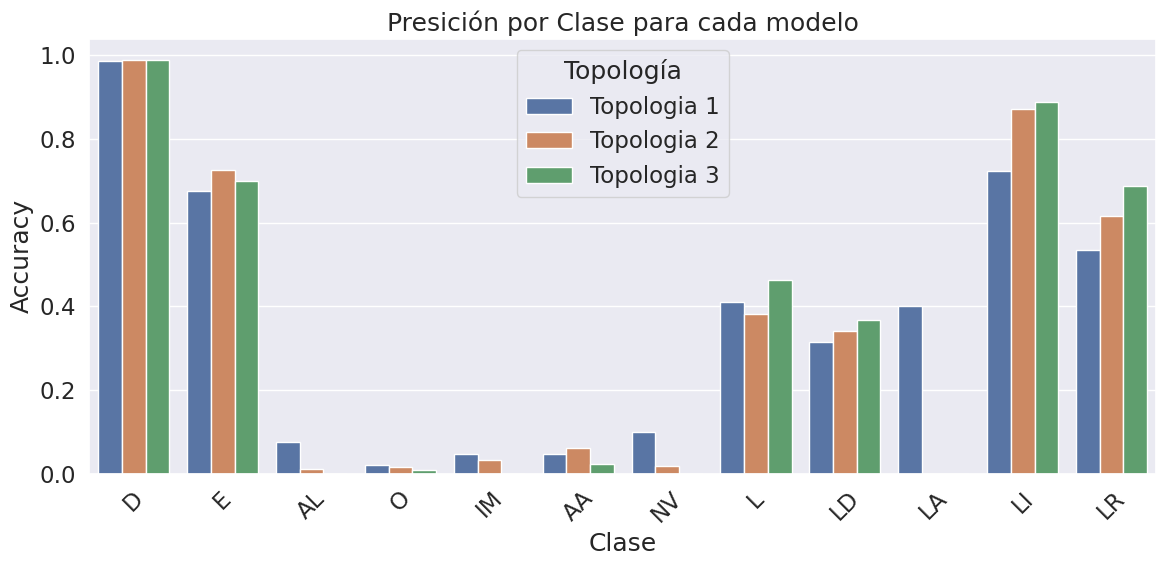

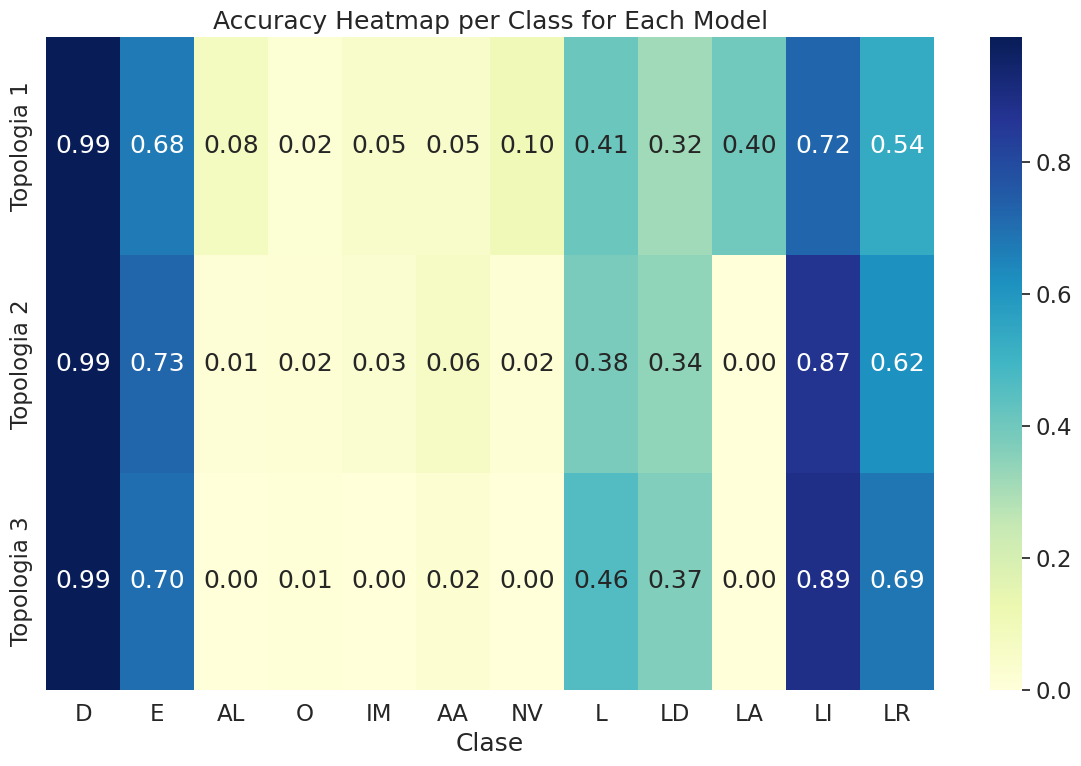

In [41]:
# melt for visualization
resultados_acc_melt = resultados_acc.melt(id_vars='Clase', var_name='Topologia', value_name='Accuracy')

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Clase', y='Accuracy', hue='Topologia', data=resultados_acc_melt)
plt.title('Presición por Clase para cada modelo')
plt.xlabel('Clase')
plt.ylabel('Precisión')
plt.xticks(rotation=45)
plt.legend(title='Topología')
plt.tight_layout()
plt.show()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(resultados_acc.set_index('Clase').T, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Mapa de calor de Precisión por Clase para cada modelo')
plt.tight_layout()
plt.show()

In [51]:
from tensorflow.keras.utils import plot_model

# Plot the model structure
plot_model(model_estudio3_1seg_topology1, to_file='model_structure.png', show_shapes=True)
plot_model(model_estudio3_1seg_topology2, to_file='model_structure2.png', show_shapes=True)
plot_model(model_estudio3_1seg_topology3, to_file='model_structure3.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
